#**Overview:**
This notebook handles the first part of the multimodal pipeline.
It takes the images and text reports as input and encodes them extracting the [CLS] tokens from the BERT and ViT models

#**Import Libraries**

In [ ]:
import pickle
import cv2
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import seaborn as sns
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from transformers import AutoImageProcessor, AutoModel, AutoConfig, AutoModelForImageClassification, BertForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score

#**Load image and text embeddings**

In [ ]:
drive.mount('/content/drive')
#load embeddings
with open('/content/drive/My Drive/Dissertation/Multimodal/pneumonia_embeddings2.pkl', 'rb') as f:
  loaded_embeddings = pickle.load(f)
#load images
with open('/content/drive/My Drive/Dissertation/Multimodal/filtered_images_384.pkl', 'rb') as f:
  images = pickle.load(f)

df = pd.read_csv('/content/drive/My Drive/Dissertation/Multimodal/pneumonia_embeddings2.csv')
df['embedding'] = loaded_embeddings
df['image'] = images
df.head()
display(df['embedding'][0].shape)
display(df['image'][0].shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(1536,)

(384, 384)

###**Splitting the data based on the given train validate test split**

In [ ]:
train = df[df['split']=='train']
val = df[df['split']=='validate']
test = df[df['split']=='test']
print(len(test),len(train),len(val))

331 20379 133


#**Set up the final MLP layer of the multimodal model**

In [ ]:
# custom mlp model
class MultimodalMLP(nn.Module):
    def __init__(self):
        super(MultimodalMLP, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(1536, 512) # input is 768*2
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2) #output is 2 for the number of classes to predict
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation on the output layer
        return x

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, df):
        self.data = df['embedding'].values  # The concatenated vectors
        self.labels = df['pneumonia'].values               # The labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert to torch tensors
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return data_tensor, label_tensor

# Create your dataset and dataloader
full_dataset = EmbeddingDataset(df)
train_dataset = EmbeddingDataset(train)
val_dataset = EmbeddingDataset(val)
test_dataset = EmbeddingDataset(test)

batches = 16
train_loader = DataLoader(train_dataset, batch_size=batches, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batches, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batches, shuffle=False)

In [ ]:
#set device to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_predictions


def evaluate_model_mc_id(model, dataloader, df):  # variation that returns which studies were misclassified
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    misclassified_ids = []  # Store misclassified study IDs

    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):  # Get batch index
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check for misclassifications and store study IDs
            for j in range(len(predicted)):
                if predicted[j] != labels[j]:
                    idx = i * dataloader.batch_size + j  # Calculate index in DataFrame
                    misclassified_ids.append((df['study_id'].iloc[idx], idx))

    return all_predictions, all_labels, misclassified_ids  # Return misclassified IDs

In [ ]:
model = MultimodalMLP()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5,weight_decay=1e-4)

epoch_loss = []
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    epoch_loss.append(total_loss/len(train_loader))
    # Save model weights
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Dissertation/Multimodal/Models/MLP_epoch_{epoch+1}.pth')

    # val_labels, val_predictions = evaluate_model(model, val_loader)
    # val_accuracy = accuracy_score(val_labels, val_predictions)
    # print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/20], Loss: 0.3075
Epoch [2/20], Loss: 0.0381
Epoch [3/20], Loss: 0.0272
Epoch [4/20], Loss: 0.0254
Epoch [5/20], Loss: 0.0232
Epoch [6/20], Loss: 0.0233
Epoch [7/20], Loss: 0.0211
Epoch [8/20], Loss: 0.0218
Epoch [9/20], Loss: 0.0209
Epoch [10/20], Loss: 0.0210
Epoch [11/20], Loss: 0.0212
Epoch [12/20], Loss: 0.0201
Epoch [13/20], Loss: 0.0201
Epoch [14/20], Loss: 0.0199
Epoch [15/20], Loss: 0.0198
Epoch [16/20], Loss: 0.0195
Epoch [17/20], Loss: 0.0192
Epoch [18/20], Loss: 0.0190
Epoch [19/20], Loss: 0.0193
Epoch [20/20], Loss: 0.0184


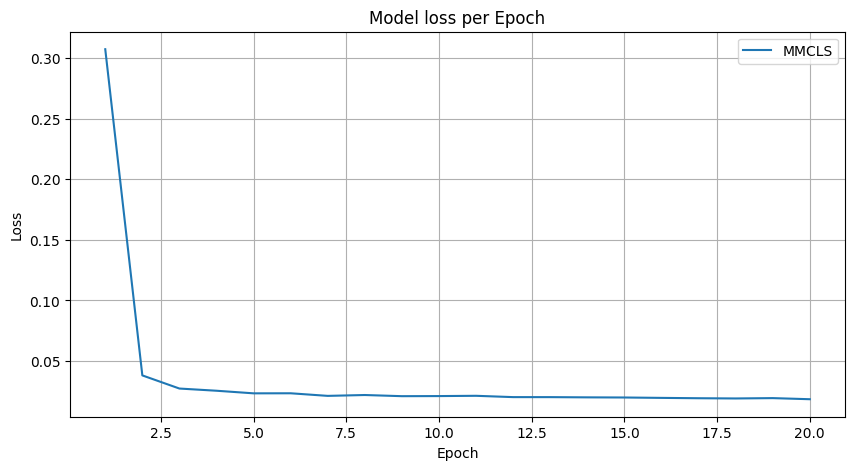

In [ ]:
 #plot model loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_loss, label = 'MMCLS')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Model loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Evaluate Model

In [ ]:
#taking a random sample from the training data for comparison
size = int(len(val))
ridx = torch.randperm(len(train))[:size]
train_sample = torch.utils.data.Subset(train_dataset, ridx)
train_sample_loader = DataLoader(train_sample, batch_size=batches, shuffle=False)
int(size/batches+1)

9

In [ ]:
all_preds_val = []
all_labels_val = []
all_preds_train = []
all_labels_train = []
for epoch in range(epochs):

    model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/Multimodal/Models/MLP_epoch_{epoch+1}.pth',weights_only=True))
    model.to(device)  # Move model to device if necessary

    # Evaluate on validation set
    val_labels, val_predictions = evaluate_model(model, val_loader)
    train_labels, train_predictions = evaluate_model(model, train_sample_loader)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    all_preds_val.append(val_predictions)
    all_labels_val.append(val_labels)
    all_preds_train.append(train_predictions)
    all_labels_train.append(train_labels)
    print(f'Epoch {epoch}')
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
    print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

Epoch 0
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 1
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 2
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 3
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 4
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 5
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 6
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 7
Validation Accuracy: 96.99%
Train Accuracy: 100.00%
Epoch 8
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 9
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 10
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 11
Validation Accuracy: 96.24%
Train Accuracy: 100.00%
Epoch 12
Validation Accuracy: 96.99%
Train Accuracy: 100.00%
Epoch 13
Validation Accuracy: 96.99%
Train Accuracy: 100.00%
Epoch 14
Validation Accuracy: 96.99%
Train Accuracy: 100.00%
Epoch 15
Validation Accuracy: 96.99%
Train Accuracy: 100.00%
Epoch 16
Validation Accuracy: 96.2

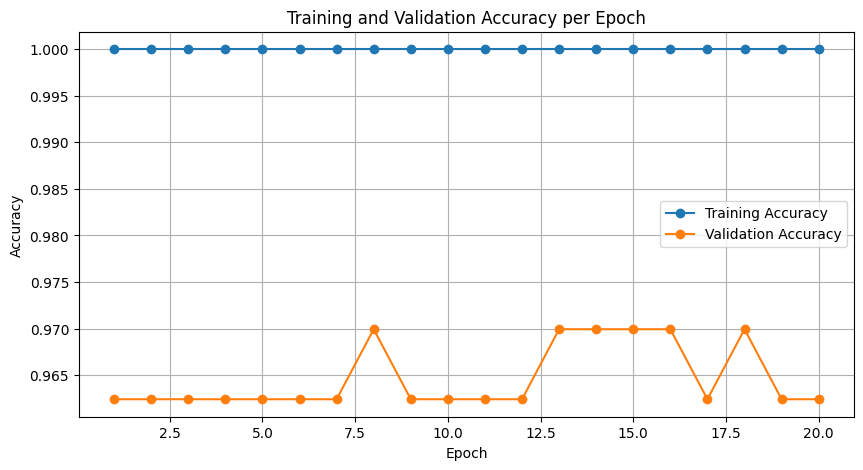

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy values for each epoch
train_accuracies = []
val_accuracies = []
# Calculate accuracy for each epoch
for epoch in range(10):
    # Training accuracy
    train_accuracy = accuracy_score(all_preds_train[epoch],all_labels_train[epoch])
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    val_accuracy = accuracy_score(all_preds_val[epoch],all_labels_val[epoch])
    val_accuracies.append(val_accuracy)


#save accuracies to a file
with open(f'/content/drive/My Drive/Dissertation/Multimodal/val_accuracies.pkl', 'wb') as f:
    pickle.dump(val_accuracies, f)

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title(f'{filename}\nTraining and Validation Accuracy per Epoch')
plt.title(f'Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Load the highest performing model
max(val_accuracies)
best_epoch = val_accuracies.index(max(val_accuracies))
# best_epoch = 5
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/Multimodal/Models/MLP_epoch_{best_epoch+1}.pth',weights_only=True))
# find misclassified studies
val_predictions, val_labels, val_mc_ids = evaluate_model_mc_id(model, val_loader,val)

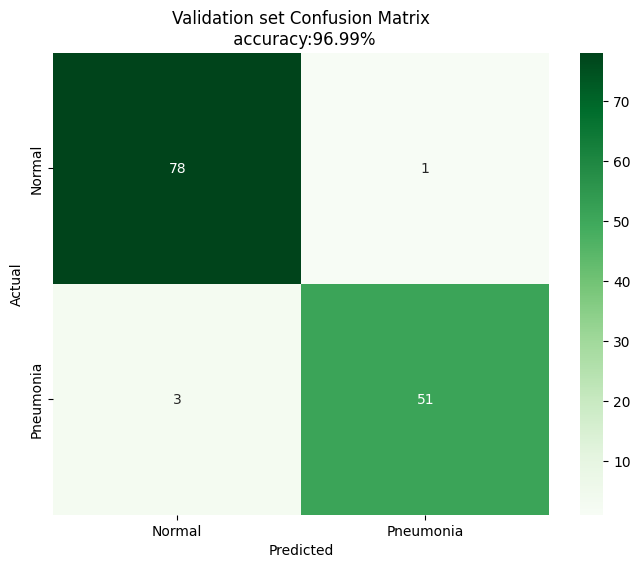

              precision    recall  f1-score   support

           0     0.9630    0.9873    0.9750        79
           1     0.9808    0.9444    0.9623        54

    accuracy                         0.9699       133
   macro avg     0.9719    0.9659    0.9686       133
weighted avg     0.9702    0.9699    0.9698       133



In [ ]:
#confusion matrix on val_labels and val_predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Validation set Confusion Matrix\n accuracy:{val_accuracy * 100:.2f}%')
plt.show()

print(classification_report(val_labels, val_predictions,digits=4))

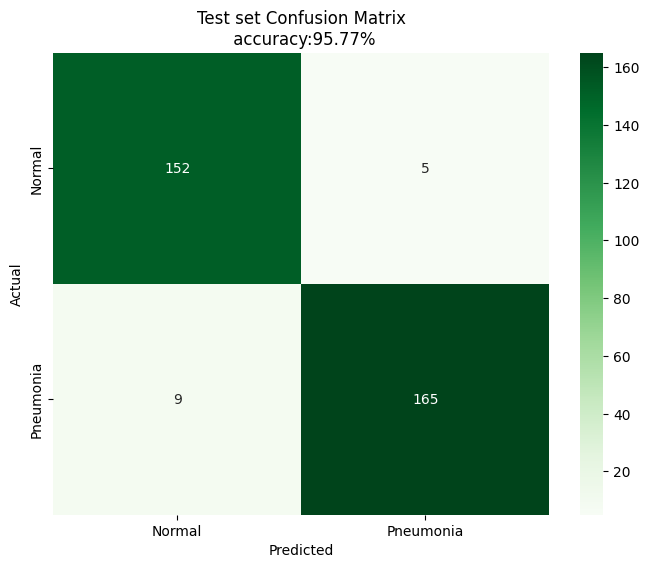

              precision    recall  f1-score   support

           0     0.9441    0.9682    0.9560       157
           1     0.9706    0.9483    0.9593       174

    accuracy                         0.9577       331
   macro avg     0.9573    0.9582    0.9576       331
weighted avg     0.9580    0.9577    0.9577       331



In [ ]:
#confusion matrix on TEST SET
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_predictions, test_labels, test_mc_ids = evaluate_model_mc_id(model, test_loader,test)
cm = confusion_matrix(test_labels, test_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Test set Confusion Matrix\n accuracy:{test_accuracy * 100:.2f}%')
plt.show()

print(classification_report(test_labels, test_predictions,digits=4))

#**Investigating Misclassified Studies**

*Disclaimer: Since I am no expert in  x-ray image diagnosis, I will not be able to comment on the x-ray image data in great detail, some comments can be made on the reports however*

In [ ]:
_,_,test_mc_ids =evaluate_model_mc_id(model, test_loader,test)

In [ ]:
# get only the ids from the tuple list
mc_idx = [item[1] for item in test_mc_ids]
mc_ids = [item[0] for item in test_mc_ids]
test_mc_ids

[(51130329, 30),
 (51130329, 31),
 (52215519, 107),
 (52215519, 108),
 (50643762, 122),
 (58701930, 142),
 (57983519, 168),
 (57983519, 169),
 (50918803, 189),
 (59875098, 210),
 (55340847, 225),
 (51246566, 246),
 (53458025, 255),
 (50269116, 304)]

In [ ]:
#locate index for val_mc_ids on df
mc_idx = test.loc[test['study_id'].isin(mc_ids)].index.tolist()
test.loc[test['study_id'].isin(mc_ids)]

,study_id,text,dicom_id,subject_id,ViewPosition,pneumonia,split,embedding,image
1148,51130329,FINAL REPORT\...,adf296d0-4fd5ce49-a34b75c5-450e6912-f2fba814,15259244,AP,1,test,"[0.77984846, -0.8897091, -0.19005305, 0.656834...","[[248, 248, 248, 249, 249, 248, 248, 249, 249,..."
1149,51130329,FINAL REPORT\...,b3a59eff-ce2b4a69-c5090087-1a2a391b-2605a57c,15259244,AP,1,test,"[0.77984846, -0.8897091, -0.19005305, 0.656834...","[[248, 248, 248, 249, 249, 248, 248, 249, 249,..."
6497,52215519,FINAL REPORT\...,31906fe2-67987de0-a8b0d659-dc6233b2-bf24da51,16508811,PA,1,test,"[0.52225477, -0.9664423, -0.25205636, 0.547848...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6498,52215519,FINAL REPORT\...,9367b100-a7a0afff-943d155e-be050317-86dce692,16508811,PA,1,test,"[0.52225477, -0.9664423, -0.25205636, 0.547848...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6696,50643762,FINAL REPORT\...,d021c1f9-134fd8f8-e73a3e87-387d59f4-ea4ea7a6,16553329,AP,1,test,"[0.8486433, -1.1784656, 0.26575536, 0.39749315...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7099,58701930,FINAL REPORT\...,463d2a28-b411bb98-f7bda38e-7030ebb9-74a8a1e0,16662264,AP,1,test,"[0.20009325, -0.89623845, -0.35124916, 0.96981...","[[224, 223, 222, 222, 221, 222, 220, 218, 219,..."
8588,57983519,FINAL REPORT\...,942b87db-92f73c39-9eae876d-2731e13d-fd427d86,17032538,AP,0,test,"[-0.012679524, -0.48080102, -1.1667832, 0.7010...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."
8589,57983519,FINAL REPORT\...,c620517c-54116688-14dadd50-6b22f911-d5812c38,17032538,AP,0,test,"[-0.012679524, -0.48080102, -1.1667832, 0.7010...","[[12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, ..."
10089,50918803,FINAL REPORT\...,809123a3-3a8ec764-0d6f069f-d1b0935b-161bfff4,17398573,PA,1,test,"[0.47052878, -0.8658381, 0.25373036, 0.5441397...","[[7, 10, 10, 6, 8, 9, 10, 8, 7, 7, 2, 6, 10, 5..."
12455,59875098,FINAL REPORT\...,9188d253-7432f199-b8668189-c4b015e6-24ed4f79,17962324,PA,0,test,"[-0.6197722, 0.23156768, -0.9343988, 0.3967842...","[[0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,..."


In [ ]:
mc_subset = torch.utils.data.Subset(full_dataset, mc_idx)
mc_loader = DataLoader(mc_subset, batch_size=batches, shuffle=False)

In [ ]:
_,_,mc_idx2 = evaluate_model_mc_id(model, mc_loader,df)

In [ ]:
print("Misclissified studies:")
model.eval()
fp = [] # track false positives
fn = [] # track false negatives
with torch.no_grad():
    for idx in mc_idx:
        data, label = full_dataset[idx]
        data = data.unsqueeze(0).to(device)
        output = model(data)
        _, predicted = torch.max(output, 1) #get predicted label
        print(f"Index: {idx}, Output: {output}, Predicted Label: {predicted.item()}, True Label: {label}")
        if predicted.item() != label:
          if predicted.item() == 1 and label == 0:
            fp.append(idx)
          elif predicted.item() == 0 and label == 1:
            fn.append(idx)

Misclissified studies:
Index: 1148, Output: tensor([[ 0.6658, -0.8734]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 1149, Output: tensor([[ 0.6779, -0.9072]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 6497, Output: tensor([[ 1.5090, -1.4632]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 6498, Output: tensor([[ 1.4879, -1.9400]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 6696, Output: tensor([[ 4.4094, -5.4382]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 7099, Output: tensor([[ 0.0242, -0.1425]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 8588, Output: tensor([[-1.0120,  1.5594]], device='cuda:0'), Predicted Label: 1, True Label: 0
Index: 8589, Output: tensor([[-1.0018,  1.2781]], device='cuda:0'), Predicted Label: 1, True Label: 0
Index: 10089, Output: tensor([[ 2.4856, -3.4718]], device='cuda:0'), Predicted Label: 0, True Label: 1
Index: 12455, Output: tensor([[-2.6963,  4.0724]], device=

In [ ]:
#function to display the radiology images
def display_image(image):
  if len(image.shape) == 3:
      image = np.transpose(image, (1, 2, 0))  # Transpose if it's a 3D array (e.g., color image)

  fig, axs = plt.subplots(1,1, figsize=(10,5))
  axs.imshow(image, cmap = 'gray')
  axs.axis('off')
  axs.set_title('x-ray image')
  plt.show()
  return None

#False Positives:

In [ ]:
df.iloc[fp]

,study_id,text,dicom_id,subject_id,ViewPosition,pneumonia,split,embedding,image
8588,57983519,FINAL REPORT\...,942b87db-92f73c39-9eae876d-2731e13d-fd427d86,17032538,AP,0,test,"[-0.012679524, -0.48080102, -1.1667832, 0.7010...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."
8589,57983519,FINAL REPORT\...,c620517c-54116688-14dadd50-6b22f911-d5812c38,17032538,AP,0,test,"[-0.012679524, -0.48080102, -1.1667832, 0.7010...","[[12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, ..."
12455,59875098,FINAL REPORT\...,9188d253-7432f199-b8668189-c4b015e6-24ed4f79,17962324,PA,0,test,"[-0.6197722, 0.23156768, -0.9343988, 0.3967842...","[[0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,..."
14161,55340847,FINAL REPORT\...,093baa2b-62a8c5b2-9255859f-2edf2dcf-4f5ed090,18343726,PA,0,test,"[-0.3092152, -0.09417477, -1.1594903, 0.603643...","[[229, 251, 232, 178, 150, 109, 91, 77, 73, 62..."
19763,50269116,FINAL REPORT\...,d21a9727-19732ca3-04b1e396-f706bb33-063c90b8,19759491,AP,0,test,"[-0.8216784, 0.60420126, -0.9762245, 0.0173425...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
print(df['text'].iloc[fp[3]])

                                 FINAL REPORT
 REASON FOR EXAMINATION:  Followup of the patient with prior radiograph showing
 left lower lobe pneumonia.
 
 PA and lateral upright chest radiographs were reviewed in comparison to
 ___.
 
 Heart size is normal.  Mediastinum is normal.  There is interval improvement,
 but no complete resolution of the left lower lobe opacity.  There are no new
 opacities noted to suggest new infectious process.  There is no pleural
 effusion.  There is no pneumothorax.
 
 IMPRESSION:
 1.  Partial improvement of previously demonstrated left lower lobe pneumonia. 
 Reevaluation of the patient in four weeks with chest radiograph is recommended
 for documentation of complete resolution.  If clinically warranted, assessment
 with chest CT might be considered.
 
 2.  Suspected hiatal hernia.



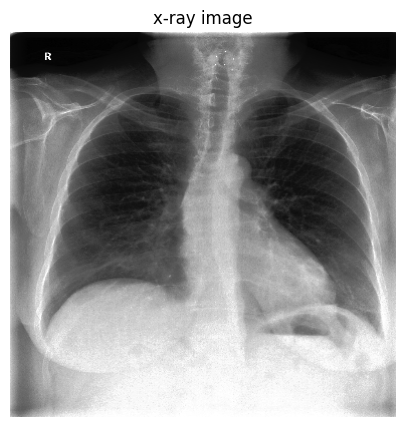

In [ ]:
display_image(df['image'].iloc[fp[3]])

This type I error (False Positive) maybe due to the fact that in the report the following is mentioned: "*No focal airspace consolidation is seen to
 suggest pneumonia*".
The model's text representation may have taken this specific part **"is seen to
 suggest pneumonia"** and did not capture the full context of the report correctly.

In [ ]:
print(df['text'].iloc[fp[4]])

                                 FINAL REPORT
 PORTABLE CHEST ___
 
 COMPARISON:  ___ radiograph.
 
 FINDINGS:  Cardiac silhouette remains enlarged, and is accompanied by
 pulmonary vascular congestion and a mild interstitial edema.  Left
 retrocardiac opacity has slightly improved, could reflect improving
 atelectasis or a resolving pneumonia in the appropriate clinical setting. 
 Adjacent small left pleural effusion is also slightly smaller.  No visible
 pneumothorax.



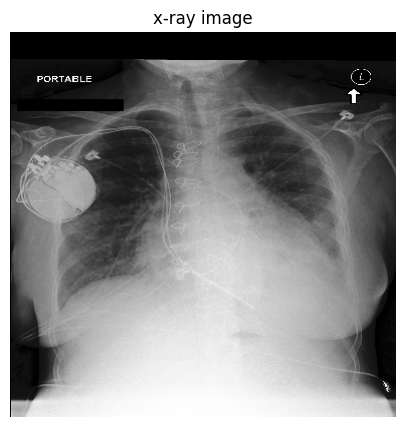

In [ ]:
display_image(df['image'].iloc[fp[4]])

Based on the report and x-ray image, there is indication that the patient does indeed have pneumonia. The left lower edge of the lung cavity seems to have absorbed the x-rays indicating possible fluid buildup. The report also indicates that pneumonia maybe present. This seems like a case of mislabelled data rather than incorrect diagnosis of the model.

#False Negatives

In [ ]:
df.iloc[fn]

,study_id,text,dicom_id,subject_id,ViewPosition,pneumonia,split,embedding,image
1148,51130329,FINAL REPORT\...,adf296d0-4fd5ce49-a34b75c5-450e6912-f2fba814,15259244,AP,1,test,"[0.77984846, -0.8897091, -0.19005305, 0.656834...","[[248, 248, 248, 249, 249, 248, 248, 249, 249,..."
1149,51130329,FINAL REPORT\...,b3a59eff-ce2b4a69-c5090087-1a2a391b-2605a57c,15259244,AP,1,test,"[0.77984846, -0.8897091, -0.19005305, 0.656834...","[[248, 248, 248, 249, 249, 248, 248, 249, 249,..."
6497,52215519,FINAL REPORT\...,31906fe2-67987de0-a8b0d659-dc6233b2-bf24da51,16508811,PA,1,test,"[0.52225477, -0.9664423, -0.25205636, 0.547848...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6498,52215519,FINAL REPORT\...,9367b100-a7a0afff-943d155e-be050317-86dce692,16508811,PA,1,test,"[0.52225477, -0.9664423, -0.25205636, 0.547848...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6696,50643762,FINAL REPORT\...,d021c1f9-134fd8f8-e73a3e87-387d59f4-ea4ea7a6,16553329,AP,1,test,"[0.8486433, -1.1784656, 0.26575536, 0.39749315...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7099,58701930,FINAL REPORT\...,463d2a28-b411bb98-f7bda38e-7030ebb9-74a8a1e0,16662264,AP,1,test,"[0.20009325, -0.89623845, -0.35124916, 0.96981...","[[224, 223, 222, 222, 221, 222, 220, 218, 219,..."
10089,50918803,FINAL REPORT\...,809123a3-3a8ec764-0d6f069f-d1b0935b-161bfff4,17398573,PA,1,test,"[0.47052878, -0.8658381, 0.25373036, 0.5441397...","[[7, 10, 10, 6, 8, 9, 10, 8, 7, 7, 2, 6, 10, 5..."
15992,51246566,FINAL REPORT\...,fe5ade20-832e5f10-2fcedcb6-4c3c8557-e8bfb513,18828251,AP,1,test,"[0.07342346, -0.7638368, -0.8762861, 0.6431308...","[[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, ..."
16741,53458025,FINAL REPORT\...,f3baaf80-a55a5d5c-780ab97b-5fade2b1-80096e7e,19016834,PA,1,test,"[-0.10520489, -0.8203734, -0.5248287, 0.557391...","[[2, 3, 4, 5, 4, 3, 3, 3, 4, 3, 5, 3, 4, 4, 3,..."


In [ ]:
print(df['text'].iloc[fn[4]])

                                 FINAL REPORT
 PA AND LATERAL CHEST FILM, ___ AT ___ 
 
 INDICATION:  ___-year-old with weakness, question infiltrate.
 
 COMPARISON:  ___ at ___.
 
 AP and lateral chest film, ___ at ___ is submitted.
 
 IMPRESSION:
 
 Heart is upper limits of normal size given AP technique.  Mediastinal contours
 are stable.  There are scattered radiopaque nodular opacities within both
 lungs suggestive of prior granulomatous infection.  The perihilar vasculature
 is somewhat prominent.  Small layering bilateral effusions suggestive of mild
 vascular congestion.  No overt pulmonary edema.  No pleural effusions or
 pneumothorax.  No evidence of focal pneumonia.  Degenerative changes in the
 thoracic spine with no acute bony abnormality identified.



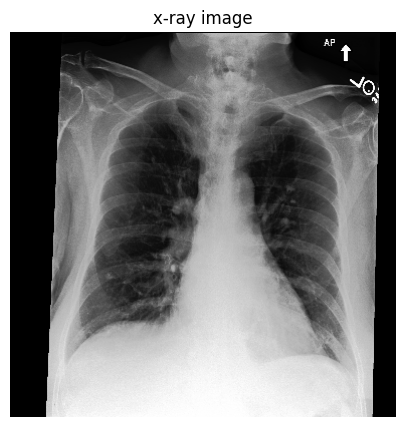

In [ ]:
display_image(df['image'].iloc[fn[4]])

This type II error (false negative) seems to be due to mislabled data since in the radiology report it is stated: "No evidence of focal pneumonia"
so it seems the model correctly classified this study.

In [ ]:
print(df['text'].iloc[fn[8]])

                                 FINAL REPORT
 INDICATION:  ___-year-old man with metastatic esophageal cancer with increased
 cough and dyspnea.  Evaluate for pneumonia.
 
 COMPARISON:  Chest radiographs ___, ___, ___; CT ___.
 
 FINDINGS:  Frontal and lateral views of the chest were obtained. The lungs are
 hyperinflated. An esophageal stent is in place.  A right basilar opacity is
 significantly improved from ___. Mild residual opacity may be scarring.
 No new opacity. Cardiac and mediastinal silhouettes and hilar contours are
 stable.  Blunting of the right costophrenic sulcus is unchanged. No left
 effusion or pneumothorax.    Loss of vertebral body height in the mid thoracic
 spine is unchanged.
 
 IMPRESSION:  Substantial clearing of the right lower lobe opacity. Mild
 residual opacity is likely scarring rather than new pneumonia. No new opacity.



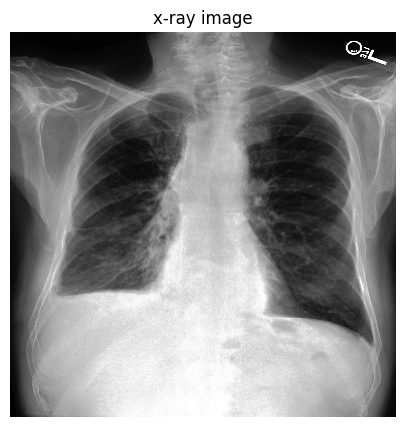

In [ ]:
display_image(df['image'].iloc[fn[8]])

In this case the report states: "Persistent moderate right pleural effusion with associated atelectasis and
 resolving pneumonia".
 This misclassification is due to the undecided nature of the report, since resolving pneumonia is ambiguous, meaning that the patient may have pneumonia but the pathology is resolving. The x-ray image seems to corroborate this fact.